## Setup Environment

In [ ]:
!pip install torchprofile 1>/dev/null

In [ ]:
!pip install torch-summary

In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs


## ResNet like Model

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict, defaultdict

class ResNetLike(nn.Module):
    ARCH = [64, 128, 'R', 256, 256, 'R', 512, 512, 'R', 512, 512, 'R'] # 'R' --> Residual Block

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        def residual_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        in_channels = 3
        for x in self.ARCH:
            if x != 'R':
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # Residual Block
                add("residual_block", ResidualBlock(in_channels, in_channels))
                add("pool", nn.MaxPool2d(2))


        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

# --- Residual Block Implementation ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample # For identity shortcut when input and output dimensions differ
        self.stride = stride

    def forward(self, x):
        identity = x # Store the input as identity

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Identity mapping - if input and output dimensions are the same, just add them
        out += identity
        out = self.relu(out) # ReLU after addition
        return out


In [ ]:
from torchsummary import summary

model = ResNetLike()
dummy_input = torch.randn(1, 3, 32, 32)
summary(model, dummy_input, depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         73,728
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─ReLU: 2-6                         [-1, 128, 32, 32]         --
|    └─ResidualBlock: 2-7                [-1, 128, 32, 32]         295,424
|    └─MaxPool2d: 2-8                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-9                       [-1, 256, 16, 16]         294,912
|    └─BatchNorm2d: 2-10                 [-1, 256, 16, 16]         512
|    └─ReLU: 2-11                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-12                      [-1, 256, 16, 16]       

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         73,728
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─ReLU: 2-6                         [-1, 128, 32, 32]         --
|    └─ResidualBlock: 2-7                [-1, 128, 32, 32]         295,424
|    └─MaxPool2d: 2-8                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-9                       [-1, 256, 16, 16]         294,912
|    └─BatchNorm2d: 2-10                 [-1, 256, 16, 16]         512
|    └─ReLU: 2-11                        [-1, 256, 16, 16]         --
|    └─Conv2d: 2-12                      [-1, 256, 16, 16]       

In [ ]:
model = model.cuda()  # Move the model to the GPU
dummy_input = dummy_input.cuda()  # Move dummy_input to the GPU
output = model(dummy_input)
print(output.shape)

torch.Size([1, 10])


## Utility functions

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()


In [ ]:
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model = model.cuda()
  model.eval()

  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
      # Move the data from CPU to GPU
      inputs = inputs.cuda()
      targets = targets.cuda()

      # Inference
      outputs = model(inputs)

      # Convert logits to class indices
      outputs = outputs.argmax(dim=1)

      # Update metrics
      num_samples += targets.size(0)
      num_correct += (outputs == targets).sum()


  return (num_correct / num_samples * 100).item()

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

## Download CIFAR10 dataset

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


## Plot dataset samples

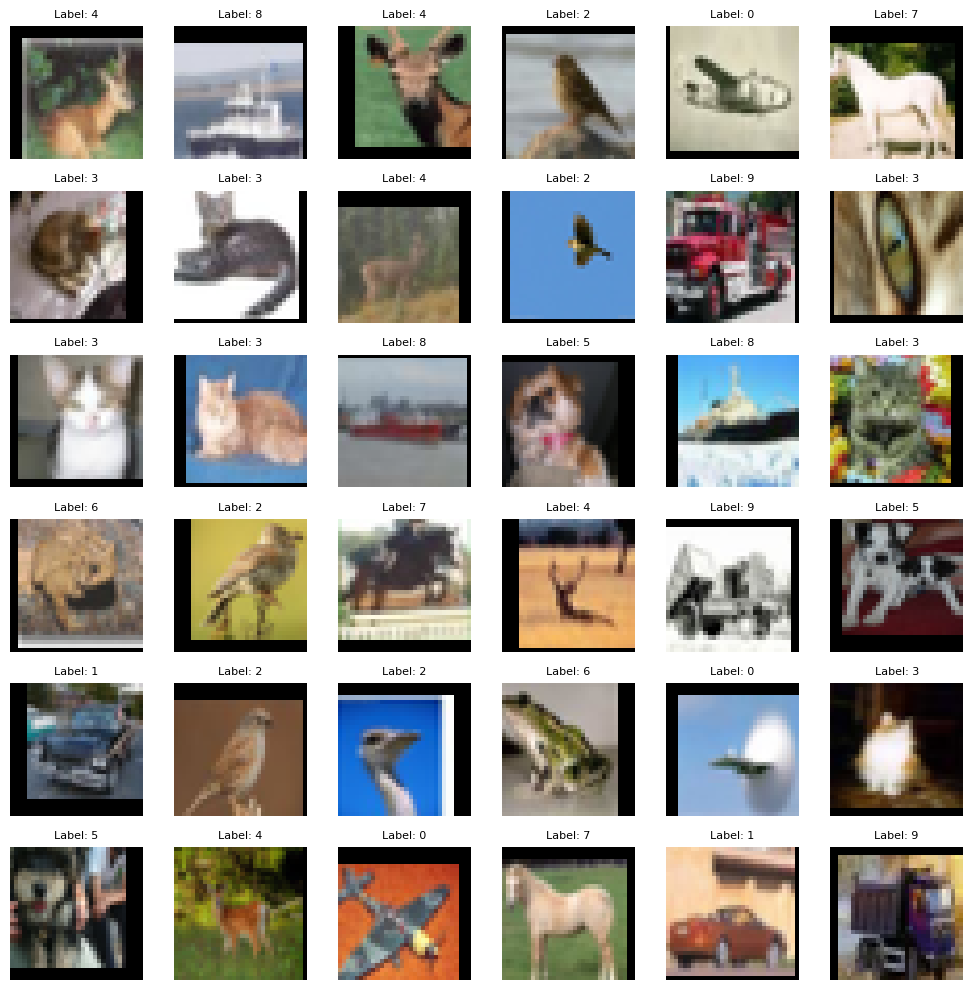

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data
images, labels = next(iter(dataloader['train']))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(6, 6, figsize=(10, 10))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Plot images in the grid
for i in range(36):  # Displaying 36 images (6x6 grid)
    image = images[i]
    image_np = image.numpy().transpose(1, 2, 0)
    axes[i].imshow(image_np)
    axes[i].set_title(f"Label: {labels[i]}", fontsize=8)  # Adjust fontsize as needed
    axes[i].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=10.00%
dense model has size=76.85 MiB


## Training Model

In [ ]:
import torch.optim as optim

model = ResNetLike()
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # You can adjust learning rate
total_steps = len(dataloader['train']) # Steps per epoch (for simplicity, let's decay per epoch step count)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: 1 - step / total_steps if step <= total_steps else 0)
num_epochs = 50


In [ ]:
print(f"Before training...")
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"Accuracy before training ={dense_model_accuracy:.4f}%")
print(f"Model size ={dense_model_size/MiB:.4f} MiB")


Before training...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy before training =10.0000%
Model size =76.8499 MiB


In [ ]:

print(f"Start training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, dataloader['train'], criterion, optimizer, scheduler) # Get train loss and accuracy
print("Training finished!")



Start training...
Epoch 1/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 31/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 32/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 33/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 34/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 35/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 36/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 37/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 38/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 39/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 40/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 41/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 42/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 43/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 44/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 45/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 46/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 47/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 48/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 49/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 50/50


train:   0%|          | 0/98 [00:00<?, ?it/s]

Training finished!


### Evaluate trained model

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=45.79%
dense model has size=76.85 MiB


### Save model

In [ ]:
# --- Saving the final model one more time after training completion ---
final_model_save_path = "model_epoch_100.pth"
torch.save(model.state_dict(), final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

Final model saved to model_epoch_100.pth


In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=45.30%
dense model has size=76.85 MiB


## Check weight distribution

IndexError: index 9 is out of bounds for axis 0 with size 9

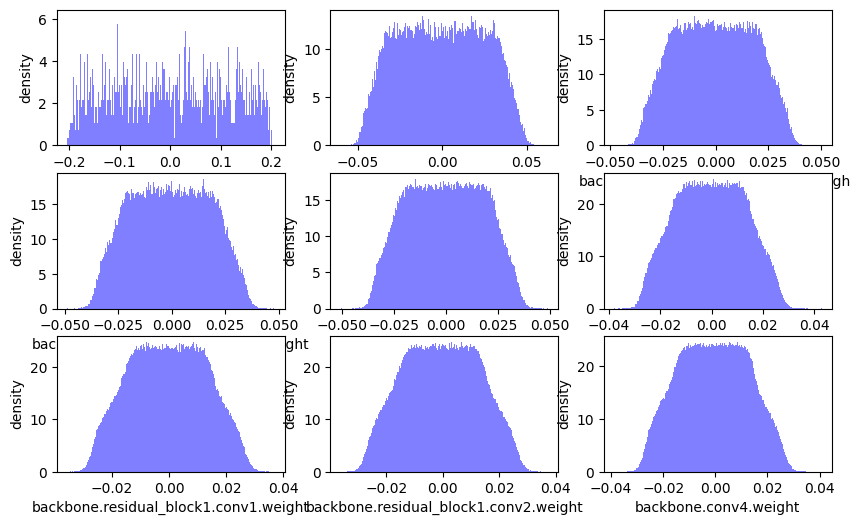

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

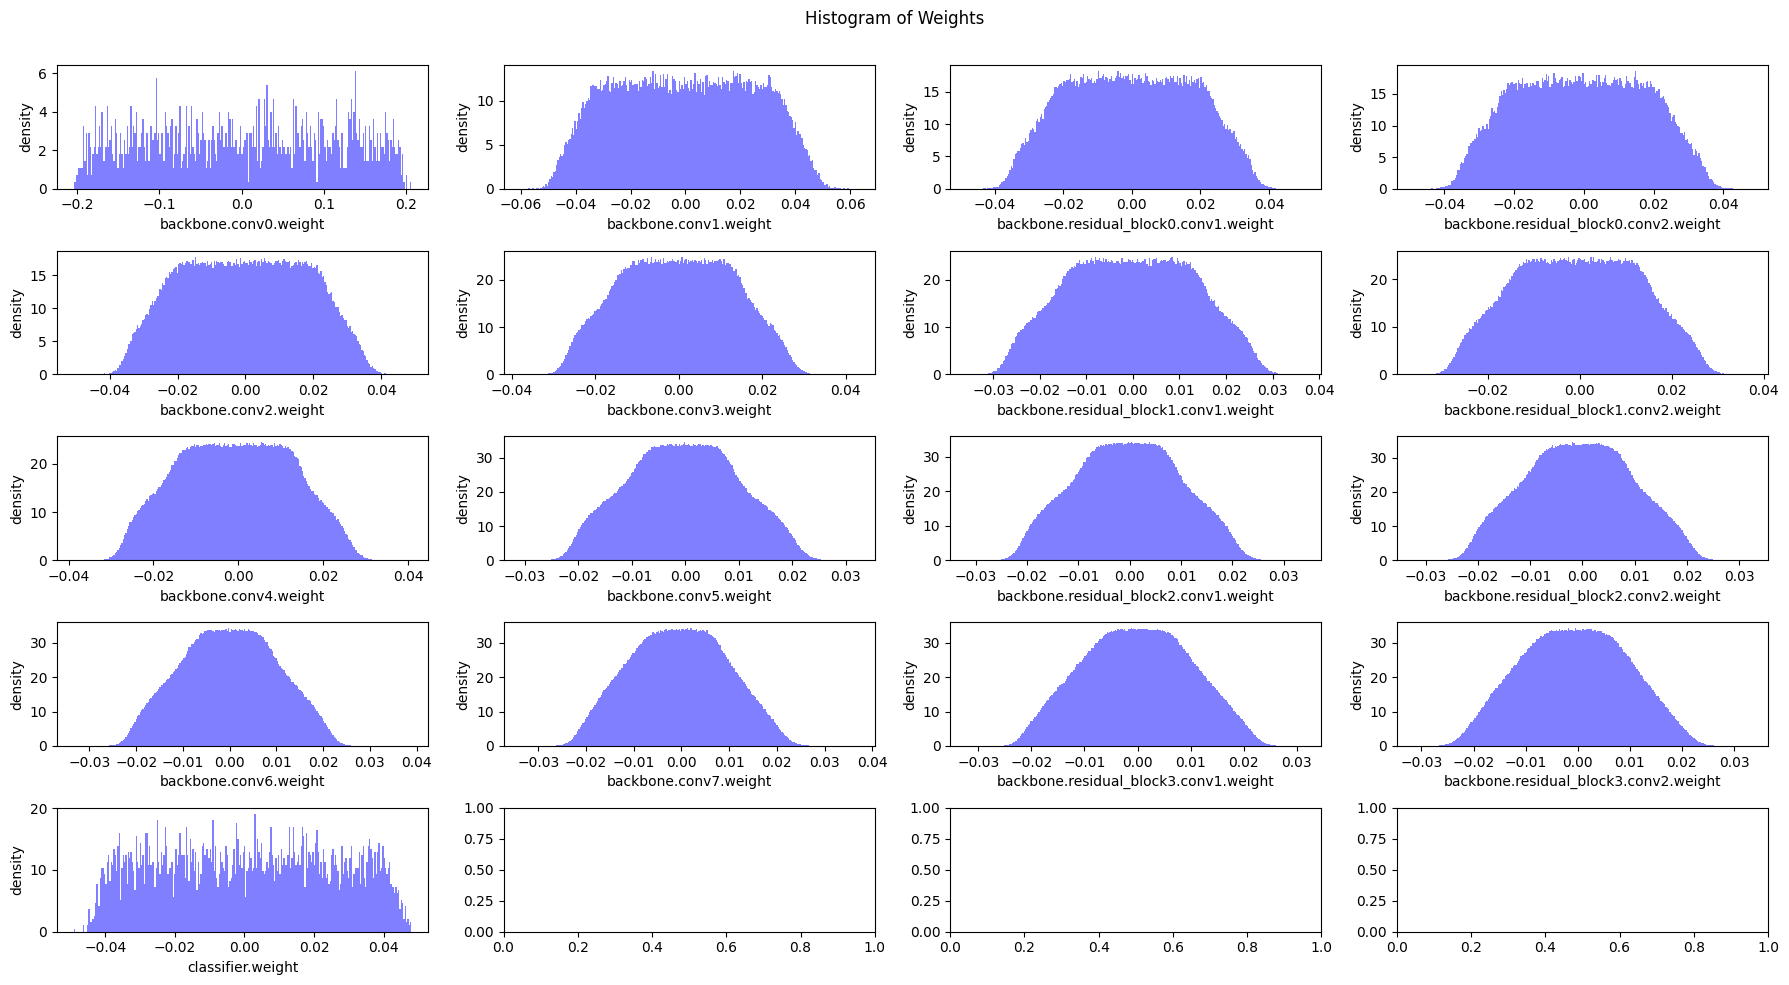

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    # Calculate the number of plots needed
    num_plots = sum(1 for name, param in model.named_parameters() if param.dim() > 1)

    # Create subplots with enough space
    num_rows = int(math.ceil(math.sqrt(num_plots)))  # Adjust rows as needed
    num_cols = int(math.ceil(num_plots / num_rows))  # Adjust columns as needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    axes = axes.ravel()  # Flatten for easier indexing
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## Fine-grained Pruning

1. Calculate the number of zeros after pruning.
2. Calculate importance of weight tensor.
3. Calculate pruning threshold to remove synapses with importance smaller than threshold.
4. Calculate pruning mask based on threshold. (mask = importance > threshold) 1 --> keep, 0 --> remove.

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold
    tensor.mul_(mask)

    return mask

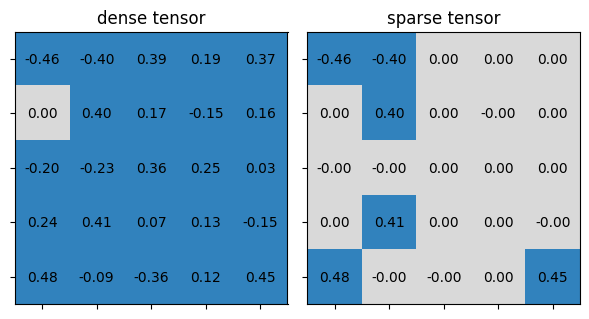

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [ ]:
test_fine_grained_prune()

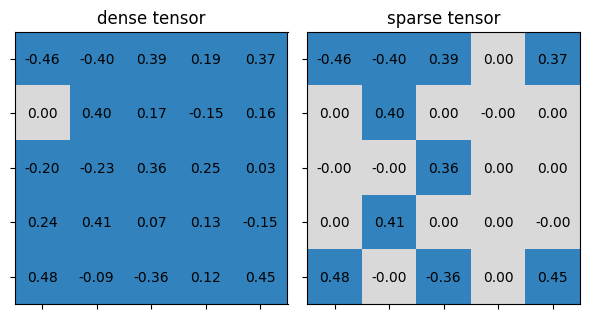

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [ ]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = (15/25) # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

### Sensitivity scan for sparsity

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/17 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[16.54%, 20.04%, 18.65%, 13.33%, 21.25%, 10.00%]

scanning 1/17 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.83%, 45.54%, 44.22%, 41.24%, 38.51%, 26.70%]

scanning 2/17 weight - backbone.residual_block0.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.67%, 45.66%, 45.48%, 45.25%, 44.90%, 39.40%]

scanning 3/17 weight - backbone.residual_block0.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.53%, 45.52%, 44.19%, 43.84%, 43.63%, 41.49%]

scanning 4/17 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.60%, 45.23%, 44.67%, 41.38%, 26.69%, 10.15%]

scanning 5/17 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.66%, 45.90%, 45.90%, 45.10%, 42.43%, 36.30%]

scanning 6/17 weight - backbone.residual_block1.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.80%, 45.78%, 45.89%, 45.84%, 45.66%, 41.22%]

scanning 7/17 weight - backbone.residual_block1.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.69%, 45.75%, 45.59%, 45.36%, 45.25%, 44.10%]

scanning 8/17 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.42%, 44.96%, 44.81%, 43.64%, 37.59%, 17.81%]

scanning 9/17 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.69%, 45.62%, 45.55%, 44.47%, 41.33%, 35.33%]

scanning 10/17 weight - backbone.residual_block2.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.69%, 45.58%, 45.48%, 45.59%, 45.01%, 42.60%]

scanning 11/17 weight - backbone.residual_block2.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.82%, 45.80%, 45.76%, 45.32%, 44.52%, 41.06%]

scanning 12/17 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.80%, 45.67%, 45.58%, 43.58%, 34.93%, 11.77%]

scanning 13/17 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.74%, 45.74%, 45.79%, 45.69%, 43.20%, 27.57%]

scanning 14/17 weight - backbone.residual_block3.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.73%, 45.59%, 45.66%, 45.73%, 46.08%, 42.88%]

scanning 15/17 weight - backbone.residual_block3.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[45.66%, 45.61%, 45.68%, 45.45%, 44.96%, 41.99%]

scanning 16/17 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[44.03%, 43.63%, 41.53%, 38.99%, 22.23%, 15.41%]

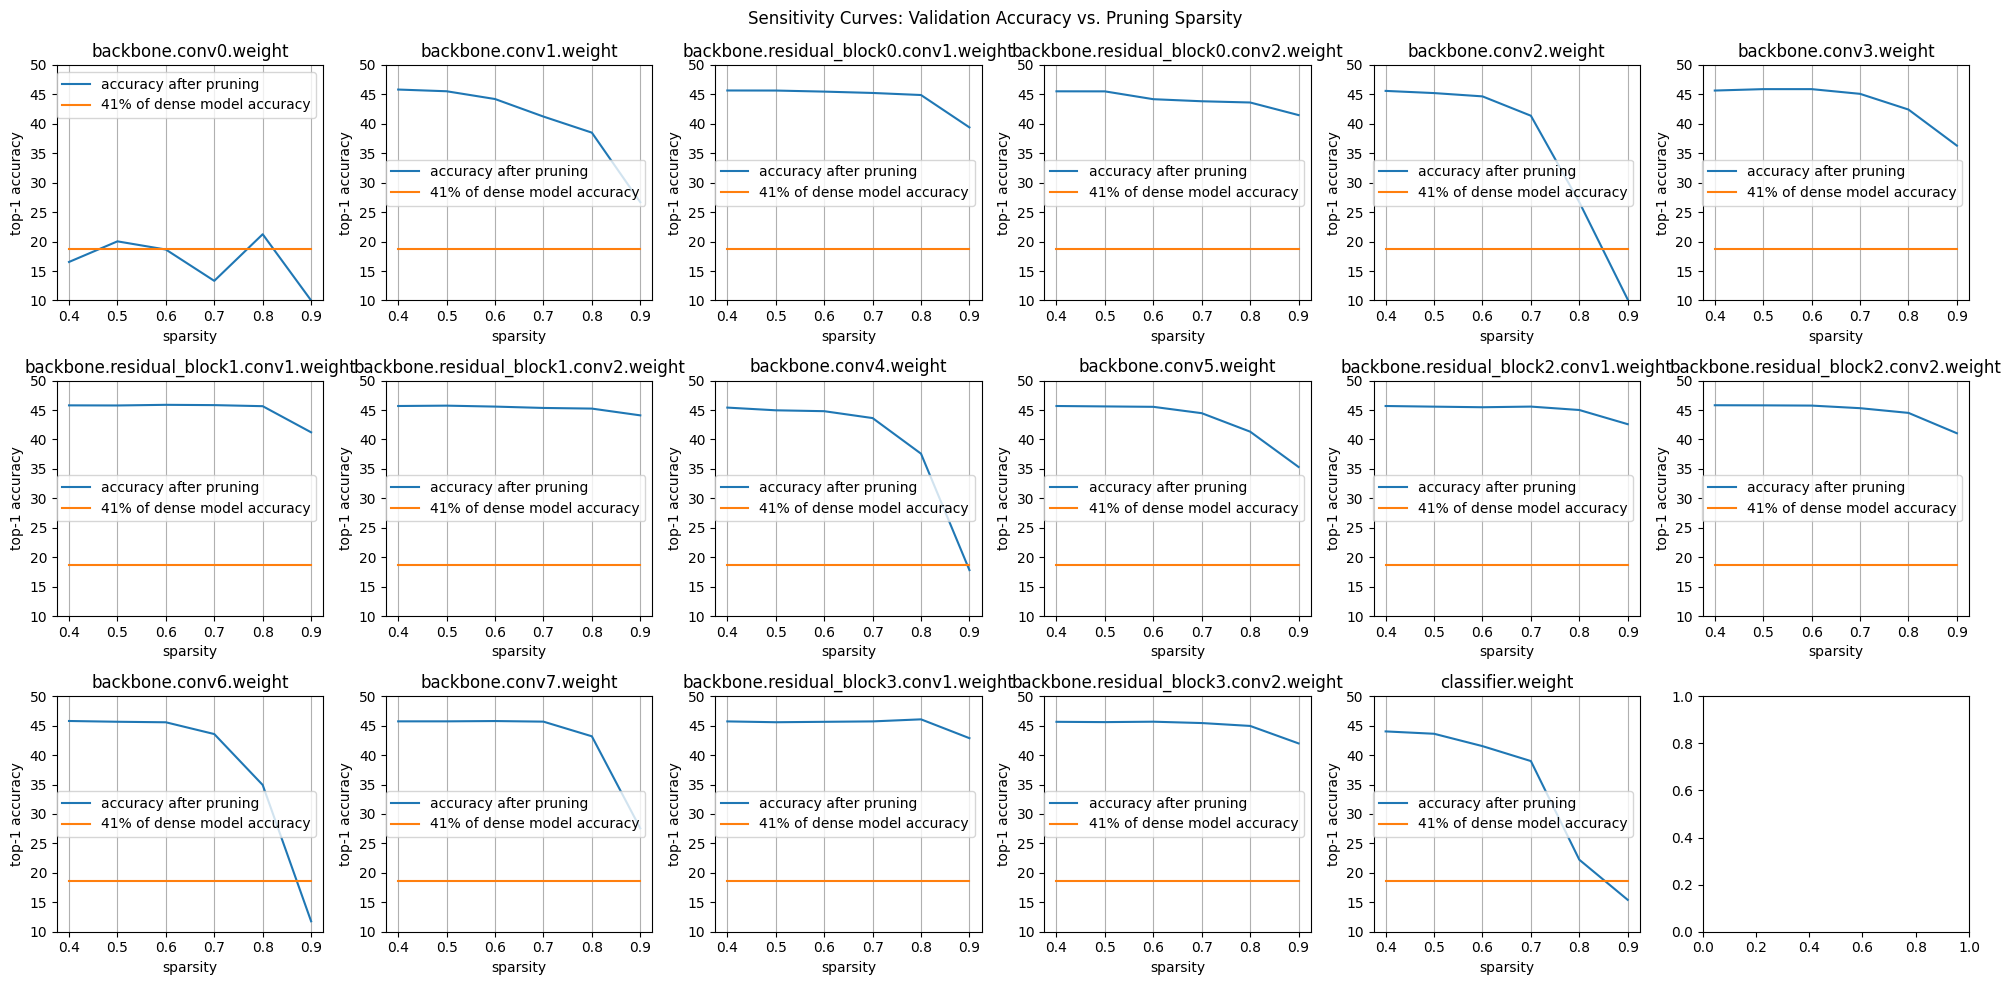

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(20,10))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(10, 50)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

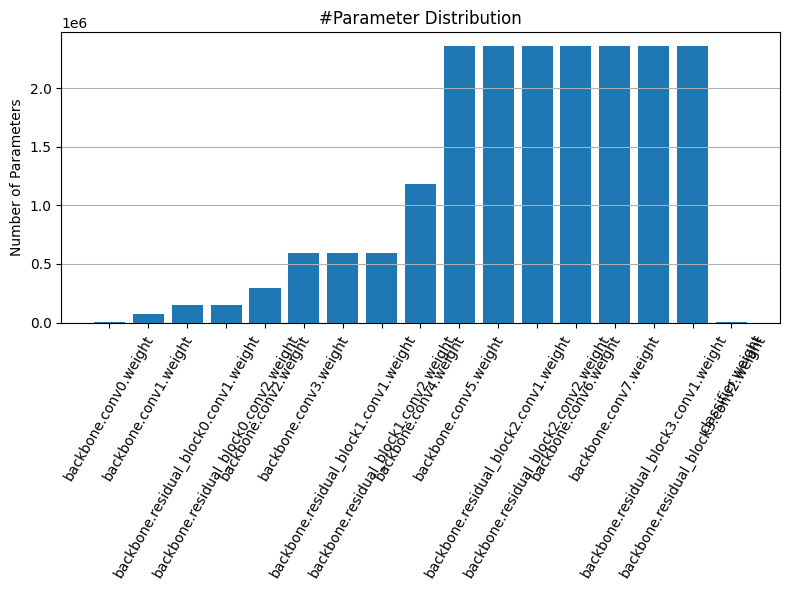

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

### Sparisity for each layer

In [ ]:
sparsity_dict = {}
for name, param in model.named_parameters():
    if param.dim() > 1:
        sparsity_dict[name] = 0.0

sparsity_dict['backbone.conv1.weight'] = 0.6
sparsity_dict['backbone.residual_block0.conv1.weight'] = 0.8
sparsity_dict['backbone.residual_block0.conv2.weight'] = 0.8
sparsity_dict['backbone.conv2.weight'] = 0.6
sparsity_dict['backbone.conv3.weight'] = 0.7
sparsity_dict['backbone.residual_block1.conv1.weight'] = 0.8
sparsity_dict['backbone.residual_block1.conv2.weight'] = 0.9
sparsity_dict['backbone.conv4.weight'] = 0.7
sparsity_dict['backbone.conv5.weight'] = 0.7
sparsity_dict['backbone.residual_block2.conv1.weight'] = 0.9
sparsity_dict['backbone.residual_block2.conv2.weight'] = 0.9
sparsity_dict['backbone.conv6.weight'] = 0.7
sparsity_dict['backbone.conv7.weight'] = 0.8
sparsity_dict['backbone.residual_block3.conv1.weight'] = 0.8
sparsity_dict['backbone.residual_block3.conv2.weight'] = 0.8
sparsity_dict

{'backbone.conv0.weight': 0.0,
 'backbone.conv1.weight': 0.6,
 'backbone.residual_block0.conv1.weight': 0.8,
 'backbone.residual_block0.conv2.weight': 0.8,
 'backbone.conv2.weight': 0.6,
 'backbone.conv3.weight': 0.7,
 'backbone.residual_block1.conv1.weight': 0.8,
 'backbone.residual_block1.conv2.weight': 0.9,
 'backbone.conv4.weight': 0.7,
 'backbone.conv5.weight': 0.7,
 'backbone.residual_block2.conv1.weight': 0.9,
 'backbone.residual_block2.conv2.weight': 0.9,
 'backbone.conv6.weight': 0.7,
 'backbone.conv7.weight': 0.8,
 'backbone.residual_block3.conv1.weight': 0.8,
 'backbone.residual_block3.conv2.weight': 0.8,
 'classifier.weight': 0.0}

### Prune model

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")


After pruning with sparsity dictionary
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.60
  backbone.residual_block0.conv1.weight: 0.80
  backbone.residual_block0.conv2.weight: 0.80
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.70
  backbone.residual_block1.conv1.weight: 0.80
  backbone.residual_block1.conv2.weight: 0.90
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.70
  backbone.residual_block2.conv1.weight: 0.90
  backbone.residual_block2.conv2.weight: 0.90
  backbone.conv6.weight: 0.70
  backbone.conv7.weight: 0.80
  backbone.residual_block3.conv1.weight: 0.80
  backbone.residual_block3.conv2.weight: 0.80
  classifier.weight: 0.00
The sparsity of each layer becomes
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.60
  backbone.residual_block0.conv1.weight: 0.80
  backbone.residual_block0.conv2.weight: 0.80
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.70
  backbone.residual_block1.conv1.weight: 0.80
  backbone.residual_block1.conv2.w

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=12.08% before fintuning


### Weight distribution after pruning

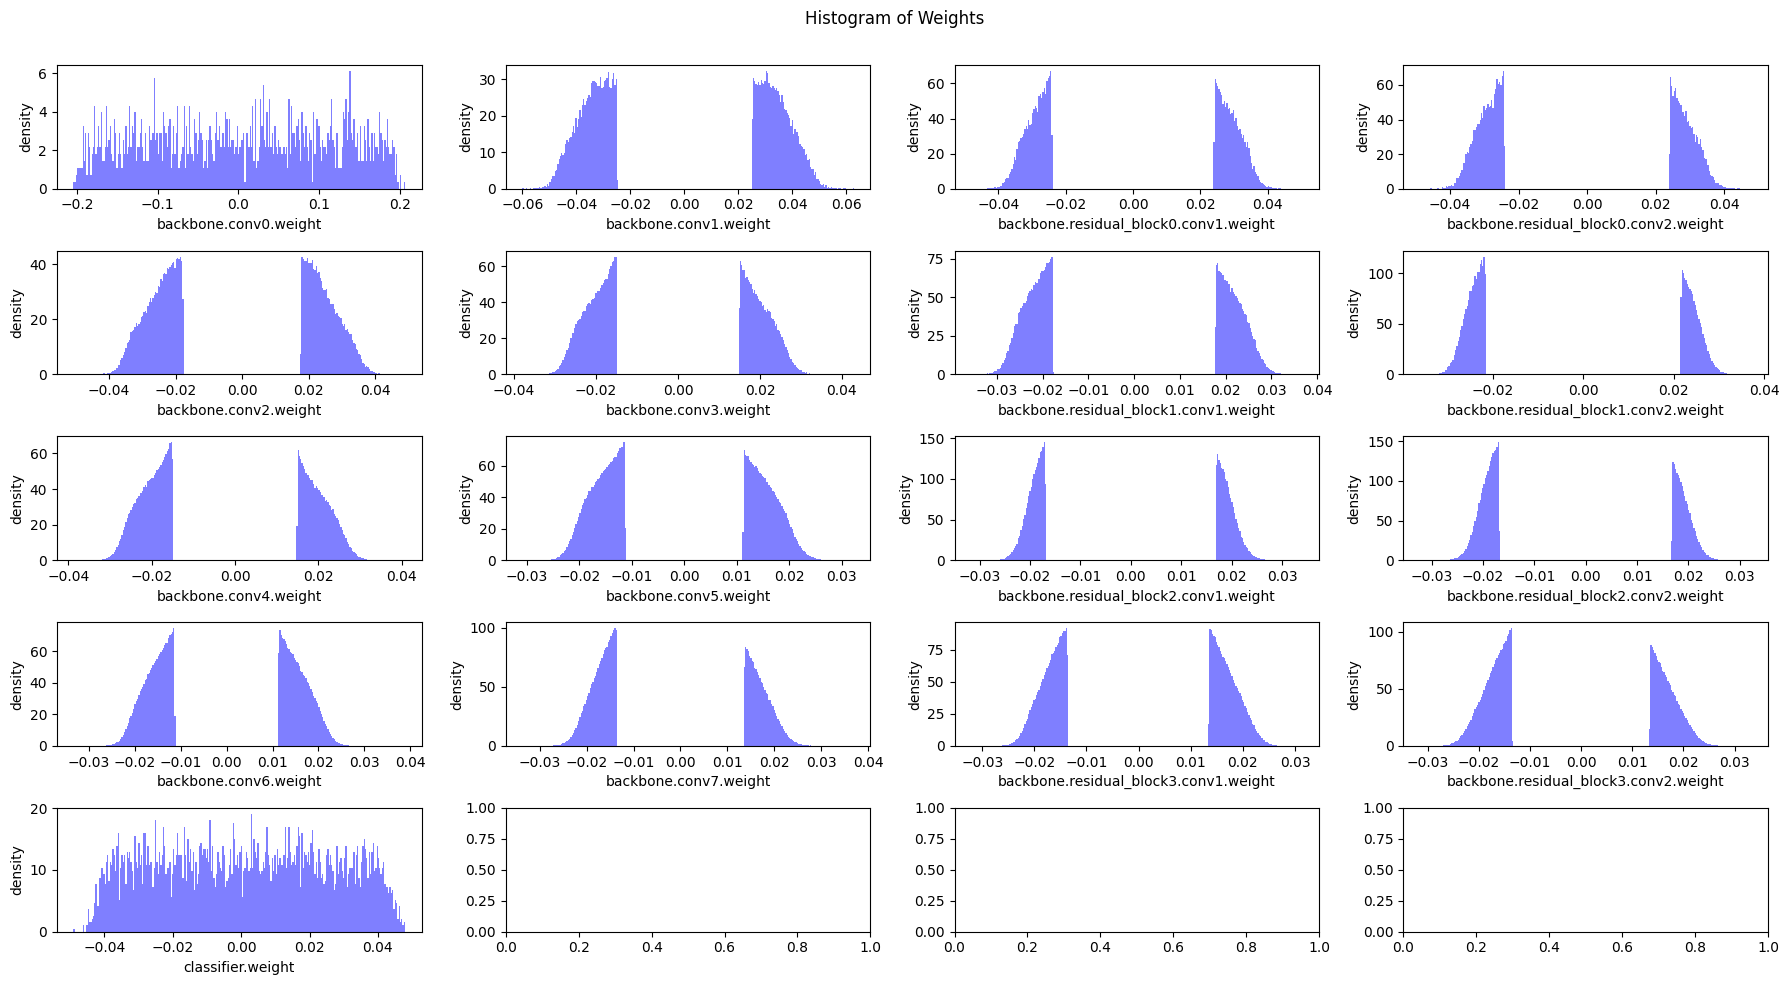

In [ ]:
plot_weight_distribution(model, count_nonzero_only=True)

## Fine tuning

In [ ]:
num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
print("-"*50)
for epoch in range(num_finetune_epochs):
    train(
        model,
        dataloader['train'],
        criterion,
        optimizer,
        scheduler,
        callbacks=[lambda: pruner.apply(model)] # apply pruning at the end of each training loop to keep model sparse
    )
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model
--------------------------------------------------


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 40.05% / Best Accuracy: 40.05%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 47.08% / Best Accuracy: 47.08%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 51.54% / Best Accuracy: 51.54%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 52.70% / Best Accuracy: 52.70%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 55.97% / Best Accuracy: 55.97%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 Accuracy 50.87% / Best Accuracy: 55.97%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 Accuracy 55.56% / Best Accuracy: 55.97%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 Accuracy 53.47% / Best Accuracy: 55.97%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 Accuracy 56.41% / Best Accuracy: 56.41%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 Accuracy 29.87% / Best Accuracy: 56.41%


In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=16.16 MiB = 21.02% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=56.41% after fintuning
